# C2ST Web Data Formatting Notebook 

## 1. Purpose

- This Notebook was created for the purpose of assisting C2ST with reformatting their web data via table exports from C2ST's monthly Google Analytics and Data Studio Reports.

## 2. Modifications

- Modifications can be made to any of the cells in this notebook.
- If a modification is necessary, it is recommended to make a copy of this notebook and test modifications to ensure things run as expected before updating the main copy. 
  - This helps preserve each notebook version so revisions are easily identifiable in the revision history.
  - Revision history can be found under "File" in the main taskbar.
- Please note that cells with images include very large amounts of code and tend to lag slightly when making edits. Text is written in between each image so it may be difficult to locate specific numbers in those cells containg images. A lot of scrolling is necessary to make modifications to these cells.
  - this will not be the case with cells containing python code or cells containing text only.

## 3. Authors

This notebook was authored by Samantha Ryan-Lee, with contributions from Nick Capaldini and Shiyu Guo. 

# Instructions and Steps

Instructions referenced from the [Survey Formatting Notebook](https://colab.research.google.com/drive/1k6pCKINHqG1SpPFlSQhy4RIG4pN-otLg?usp=sharing)

Follow the link above for additional detailed instructions and examples for:
- running notebooks
- mounting Google Drive
- inputting file names
- troubleshooting errors
- uploading and downloading files to the notebook's local file structure

# Read Before Running!

When uploading Data Studio Report exports to the c2st_data_files folder, please create a new folder for the date range of the Data Studio Report.
This way, historical web data can be tracked according to date ranges. If the files are not moved to a new folder named with the specified date range, the notebook will result in a `FileNotFound` Error.

Additionally, please create a copy of the file containing all events and move it into the newly created date range folder. If the events data file is not added to the date range folder, the notebook will result in a `FileNotFound` Error.

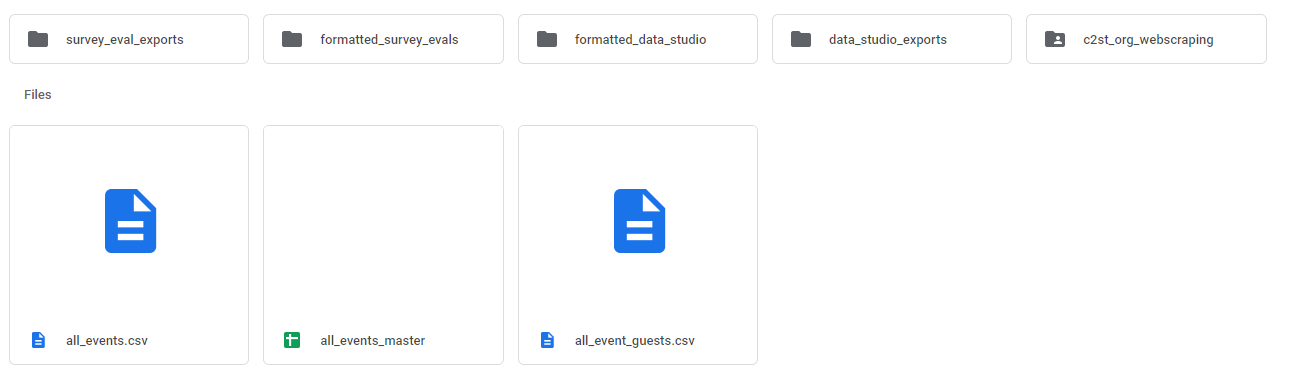

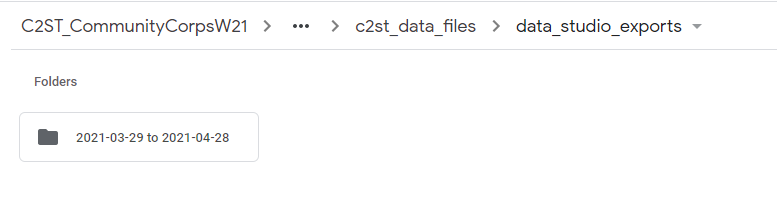

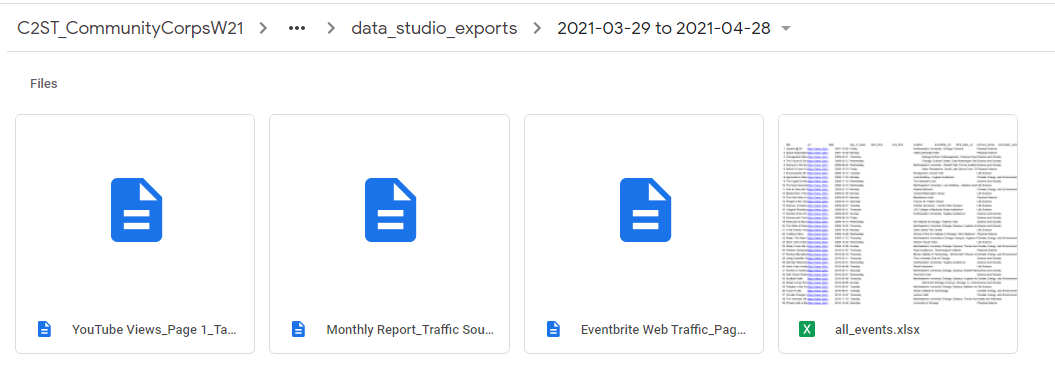

## Run the Notebook

1. Select "Runtime" from the taskbar

2. Select "Run all"

3. Alternatively, you can use the shortcut Ctrl+F9 (This shortcut may be different for Mac OS)

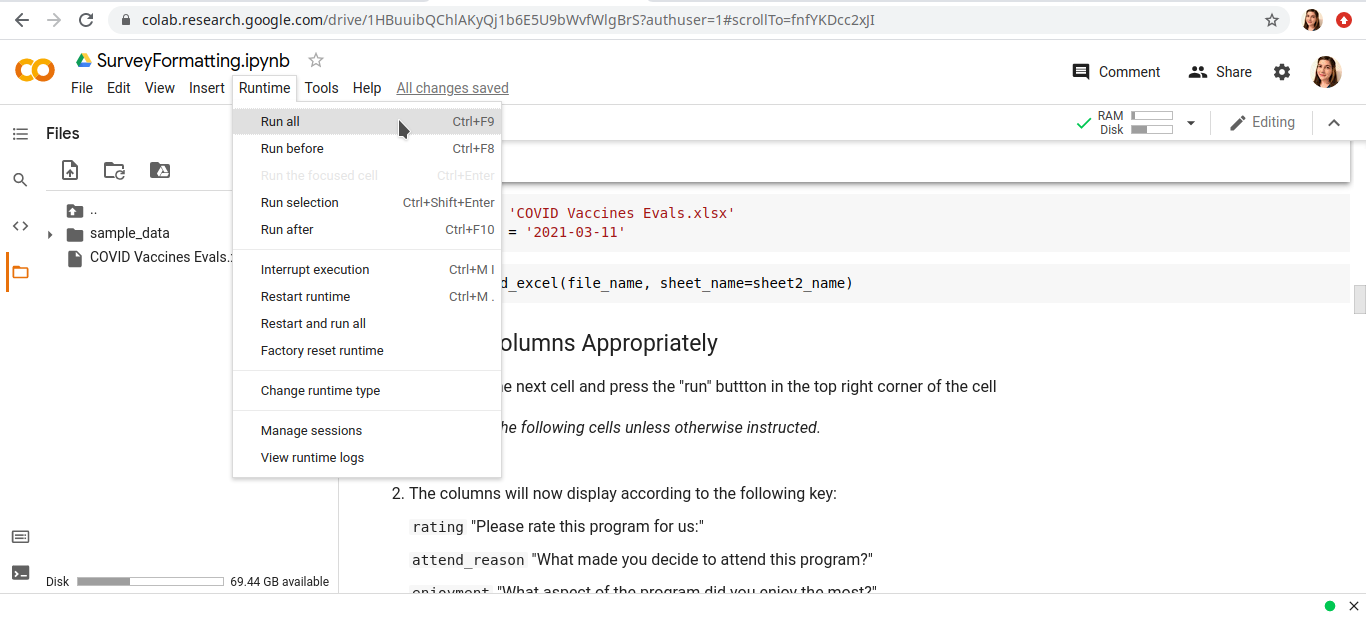


4. A warning will display. This just means that Google did not write this notebook. Not all notebooks are safe to run. This one is. Please select "Run Anyway"

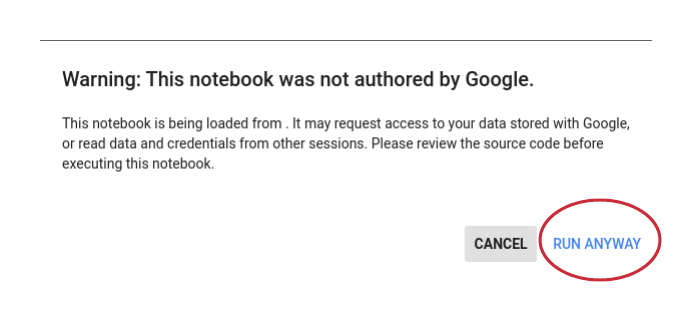

In [ ]:
# if experiencing a ModuleNotFoundError uncomment this cell and run once, then recomment
#! pip install fuzzywuzzy

In [ ]:
import pandas as pd
from fuzzywuzzy import process

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Mount Google Drive and Input File Names

Ensure all necessary Data Studio exports AND the overarching events file are copied into the 'data_studio_exports' folder located at notebooks>c2st_data_files.

Please reference the [Survey Formatting Notebook](https://colab.research.google.com/drive/1k6pCKINHqG1SpPFlSQhy4RIG4pN-otLg?usp=sharing) for detailed instructions and examples for running notebooks, mounting Google Drive, and inputting file names.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/C2ST_CommunityCorpsW21/deliverables/notebooks/c2st_data_files/data_studio_exports'

Mounted at /content/drive
/content/drive/Shareddrives/C2ST_CommunityCorpsW21/deliverables/notebooks/c2st_data_files/data_studio_exports


In [ ]:
c2storg_file_name = input("Input the file name for the Monthtly Report: ")
eventbrite_file_name = input("Input the file name for the Eventbrite Report: ")
youtube_file_name = input("Input the file name for the YouTube Report: ")
event_file_name = input("Input the name of the events file: ")
date_range = input("Input the Data Studio Report date range in the format 'YYYY-MM-DD to YYYY-MM-DD': ")

# Load Files into Notebook


In [ ]:
file_inpath = date_range + '/'

In [ ]:
c2storg_df = pd.read_csv(file_inpath + c2storg_file_name)
c2storg_df.head()

FileNotFoundError: ignored

In [ ]:
eventbrite_df = pd.read_csv(file_inpath + eventbrite_file_name)
eventbrite_df.head()

In [ ]:
youtube_df = pd.read_csv(file_inpath + youtube_file_name)
youtube_df.head()

In [ ]:
all_events_df = pd.read_excel(file_inpath + event_file_name, sheet_name='all_events')
all_events_df.head()

# Match C2ST Event Title with c2st.org Page Title

Takes c2st.org page titles from the data studio monthly report and calculates [Levenshtein Distances](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0) between page titles and C2ST event titles.

> The Levenshtein distance is a number that tells you how different two strings are. The higher the number, the more different the two strings are.

Those titles with a similarity ratio of 90 or greater are saved and linked to event numbers. *This will take several minutes to execute as there is a lot of calcuations occuring under the hood.*

In [ ]:
event_merge = all_events_df[['event_no', 'title']].copy()
event_merge.tail()

In [ ]:
c2storg_pages = c2storg_df['Page Title'].values
event_titles = all_events_df['title'].values

In [ ]:
matches = []
for page in c2storg_pages:
    highest = process.extractOne(page,event_titles)
    if highest[1] >= 90:
        #print(page, highest)
        matching_titles = {'c2st_org_page': page,
                           'event_title': highest[0], 
                           'lev_dist': highest[1]}
        matches.append(matching_titles)


In [ ]:
for match in matches:
    print(match)
    print('\n-------------------------------')

In [ ]:
matching_titles_df = pd.DataFrame(matches)
matching_titles_df.head()

In [ ]:
matching_titles_wEventno = pd.merge(matching_titles_df, event_merge, how='left', left_on='event_title', right_on='title')
matching_titles_wEventno.head()

In [ ]:
linked_c2storg_df = pd.merge(c2storg_df, matching_titles_wEventno, how='inner', left_on='Page Title', right_on='c2st_org_page')
linked_c2storg_df.head()

In [ ]:
c2storg_formatted = linked_c2storg_df[['Page Title', 'event_no', 'Pageviews', 'Avg. Time on Page', 'Bounce Rate', 'lev_dist']].copy()
c2storg_formatted.rename(columns={'Page Title': 'c2st_event_page_title', 'Pageviews': 'pageviews', 'Avg. Time on Page': 'avg_time_on_page', 'Bounce Rate': 'bounce_rate'}, inplace=True)

# Match Event Title with Eventbrite Page Title

Eventbrite pages are matched in the same way the c2st.org event pages were matched. *This will take several minutes to process.*

In [ ]:
eventbrite_pages = eventbrite_df['Page Title'].values
eventbrite_matches = []
for page in eventbrite_pages:
    highest = process.extractOne(page,event_titles)
    if highest[1] >= 90:
        #print(page, highest)
        matching_titles = {'eventbrite_page': page,
                           'event_title': highest[0], 
                           'lev_dist': highest[1]}
        eventbrite_matches.append(matching_titles)
for match in eventbrite_matches:
    print(match)
    print('\n-------------------------------')

In [ ]:
matching_eb_titles_df = pd.DataFrame(eventbrite_matches)
matching_eb_titles_df.head()

In [ ]:
matching_eb_titles_wEventno = pd.merge(matching_eb_titles_df, event_merge, how='left', left_on='event_title', right_on='title')
matching_eb_titles_wEventno.head()

In [ ]:
linked_eventbrite_df = pd.merge(eventbrite_df, matching_eb_titles_wEventno, how='inner', left_on='Page Title', right_on='eventbrite_page')
linked_eventbrite_df.head()

In [ ]:
eventbrite_formatted = linked_eventbrite_df[['Page Title', 'event_no', 'Pageviews', '% Δ', 'lev_dist']].copy()
eventbrite_formatted.rename(columns={'Page Title': 'eventbrite_page_title', 'Pageviews': 'pageviews', '% Δ': 'percent_change', 'Bounce Rate': 'bounce_rate'}, inplace=True)
eventbrite_formatted.head()

# Match Event Title with YouTube Video Title

YouTube videos are matched in the same way the c2st.org and eventbrite pages were matched. *This will take several minutes to process.*

In [ ]:
yt_videos = youtube_df['Video Title'].values
yt_matches = []
for video in yt_videos:
    highest = process.extractOne(video,event_titles)
    if highest[1] >= 90:
        #print(page, highest)
        matching_videos = {'yt_video_title': video,
                           'event_title': highest[0], 
                           'lev_dist': highest[1]}
        yt_matches.append(matching_videos)
for match in yt_matches:
    print(match)
    print('\n-------------------------------')

In [ ]:
matching_yt_titles_df = pd.DataFrame(yt_matches)
matching_yt_titles_df.head()

In [ ]:
event_merge_yt = all_events_df[['event_no', 'title']].copy()
event_merge_yt.head(15)

In [ ]:
all_events_df[all_events_df['event_no'] == 211]
event_merge_yt[event_merge_yt['event_no'] == 211]

In [ ]:
matching_yt_titles_wEventno = pd.merge(matching_yt_titles_df, event_merge_yt, how='outer', left_on='event_title', right_on='title')
matching_yt_titles_wEventno.head()

In [ ]:
linked_yt_df = pd.merge(youtube_df, matching_yt_titles_wEventno, how='inner', left_on='Video Title', right_on='yt_video_title')
linked_yt_df.head()

In [ ]:
youtube_formatted = linked_yt_df[['Video Title', 'event_no', 'Views', '% Δ', 'lev_dist']].copy()
youtube_formatted.rename(columns={'Video Title': 'yt_video_title', 'Views': 'views', '% Δ': 'percent_change'}, inplace=True)
youtube_formatted.head()

# Connect Formatted Data Studio Tables to Master File

Create a new Data Studio master file that links Specific Event numbers with web data sources.

The files will output to the "formatted_data_studio" folder in c2st_data_files located at notebooks>c2st_data_files.

**Once these files have been uploaded to the "formatted_data_studio" folder

In [ ]:
gdrive_outpath = '/content/drive/Shareddrives/C2ST_CommunityCorpsW21/deliverables/notebooks/c2st_data_files/formatted_data_studio/'
output_folder = gdrive_outpath + date_range + '/'

In [ ]:
c2storg_formatted.to_csv(output_folder + 'c2storg_datastudio_formatted.csv')
eventbrite_formatted.to_csv(output_folder + 'eventbrite_datastudio_formatted.csv')
youtube_formatted.to_csv(output_folder + 'youtube_datastudio_formatted.csv')

In [ ]:
with pd.ExcelWriter(path=outpath_folder + 'master_webdata_file.xlsx') as writer:
    all_events_df.to_excel(writer, sheet_name='events', index=False)
    c2storg_formatted.to_excel(writer, sheet_name='c2st_org', index=False)
    eventbrite_formatted.to_excel(writer, sheet_name='eventbrite', index=False)
    youtube_formatted.to_excel(writer, sheet_name='youtube', index=False)

# Troubleshooting Errors

## File Error

1. `File Not Found`

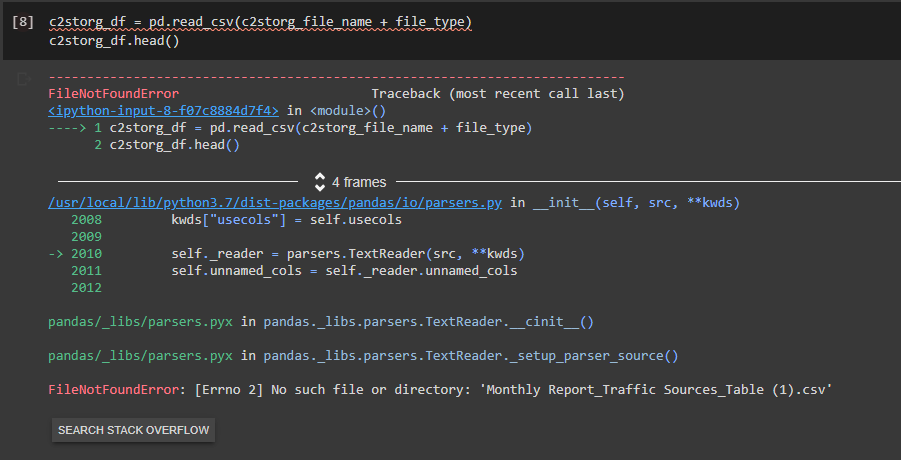

- Error shows when file name is not found in either the notebook's local file system or the mounted google drive path





### Resolving File Error

1. check for spelling mistakes in the file names
2. ensure the file name includes the correct file type tag (such as .xlsx or .csv)
3. ensure the file is located in the correct google drive folder ('survey_eval_exports') **OR** the file has been uploaded to the notebook's local file system

**If you are unable to resolve this error, please contact Samantha Ryan-Lee (sryanlee@umich.edu)**

## Environment Error

1. `ModuleNotFoundError: No module named 'fuzzywuzzy'`

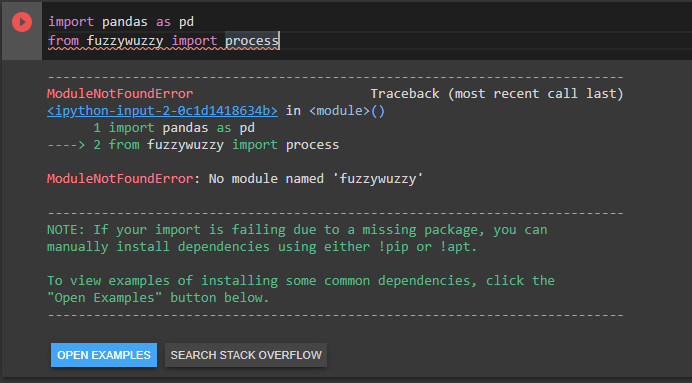

- Error shows when the local Google Colab python enviornment is missing the package 'fuzzywuzzy'. This package is necessary to match page and video titles from the web data exports.

### Resolving Enviornment Error:

1. Locate first code cell block in the notebook

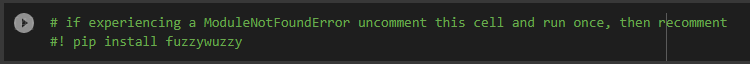

2. Uncomment the line of code that reads `#! pip install fuzzywuzzy` by deleting the `#` that precedes the `!`. The line of code should turn from green to white.

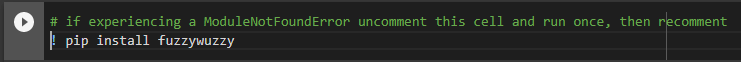

3. Run the cell by clicking the play button on the code cell block.

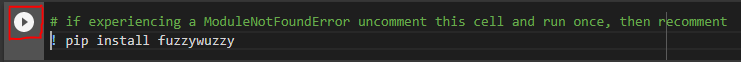

4. Recomment the line that reads `! pip install fuzzywuzzy` by typing `#` before the `!`. The line of code should turn from white green

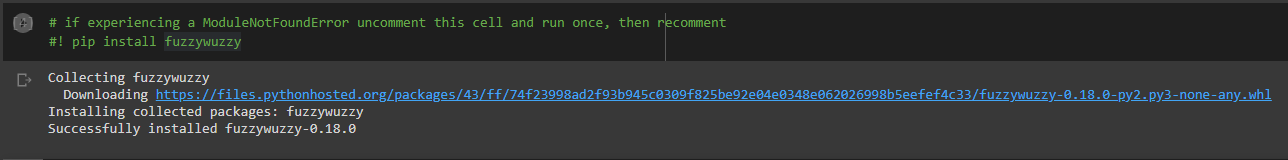

5. Run the entire notebook again. The cell intially showing the `ModuleNotFoundError` should now look like the image below.

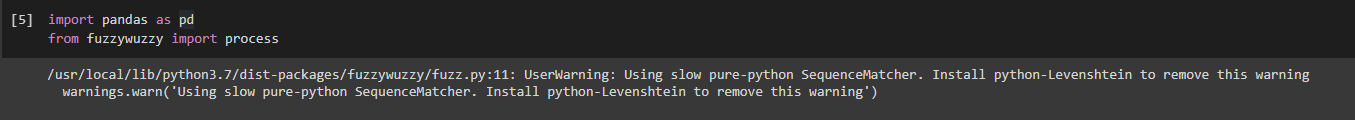